In [19]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import folium 
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
import sqlite3
import requests
import geopandas as gpd
from utils import get_osrm_distance 
import requests
from pyproj import Transformer
import os


In [20]:
data = pd.read_csv('ChargingStationCleaned.csv')
data['year'] = pd.to_datetime(data['commissioning_date']).dt.year

In [21]:
data.head()

,operator,address,house_number,placeholder1,postcode,city,federal_state,metropolitan_area,latitude_[dg],longitude_[dg],...,number_of_charging_points,type_of_plug_1,p1_[kw],type_of_plug_2,p2_[kw],type_of_plug_3,p3_[kw],type_of_plug_4,p4_[kw],year
0,EnBW mobility+ AG und Co.KG,Hauptstraï¿½e,91c,NaN,73340,Amstetten,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.578534,9.874840,...,2,AC Kupplung Typ 2,43.0,"DC Kupplung Combo, DC CHAdeMO",50.0,0,0.0,0,0.0,2019
1,SWU Energie GmbH,Lindenstraï¿½e,7,NaN,89176,Asselfingen,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.528983,10.193397,...,1,AC Steckdose Typ 2,22.0,0,0.0,0,0.0,0,0.0,2019
2,SWU Energie GmbH,ï¿½llengasse,10,NaN,89177,Ballendorf,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.553539,10.082678,...,1,AC Steckdose Typ 2,22.0,AC Steckdose Typ 2,22.0,0,0.0,0,0.0,2019
3,SWU Energie GmbH,Sterngasse,6,NaN,88481,Balzheim,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.179959,10.076977,...,1,AC Steckdose Typ 2,22.0,0,0.0,0,0.0,0,0.0,2022
4,EnBW mobility+ AG und Co.KG,Heuweg,12,NaN,89179,Beimerstetten,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.480387,9.980588,...,2,"AC Steckdose Typ 2, AC Schuko",22.0,"AC Steckdose Typ 2, AC Schuko",22.0,0,0.0,0,0.0,2019


In [22]:
def create_network(year, max_distance=100):
    data_year = data[data['year'] <= year]
    n = len(data_year)
    positions = data_year[['latitude_[dg]', 'longitude_[dg]']].to_numpy()

    # Converti le coordinate geografiche in coordinate UTM
    transformer = Transformer.from_crs('epsg:4326', 'epsg:32632', always_xy=True)
    positions_utm = np.array([transformer.transform(x[1], x[0]) for x in positions])

    network = nx.Graph()
    
    # Aggiungi i nodi al grafo con attributi di latitudine e longitudine
    for i in range(n):
        network.add_node(i + 1, latitude=positions[i, 0], longitude=positions[i, 1])

    for i in range(n):
        for j in range(i + 1, n):  # Evita di ripetere gli archi
            # distance = get_osrm_distance(positions_utm[i, 0], positions_utm[i, 1], positions_utm[j, 0], positions_utm[j, 1])
            distance = get_osrm_distance(positions[i, 0], positions[i, 1], positions[j, 0], positions[j, 1])
            if distance is not None and distance < max_distance * 1000:  # Converti max_distance in metri
                network.add_edge(i + 1, j + 1, weight=distance)

    pos = {i + 1: positions_utm[i] for i in range(n)}

    options = {
        'node_color': 'lavender',
        'node_size': 100,
        'width': 1,
        'arrowstyle': '->',
        'arrowsize': 1,
    }

    # Leggi il file GeoJSON dei confini della Germania
    germany_boundary = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/4090d4e1f89c1184b436b3d9ccaf332b4c5b43d2/2_bundeslaender/4_niedrig.geo.json')

    # Converti le coordinate geografiche in coordinate UTM
    germany_boundary = germany_boundary.to_crs('epsg:32632')

    # Crea un nuovo plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Disegna i confini della Germania
    germany_boundary.boundary.plot(ax=ax, linewidth=1, color='red')

    # Disegna il network
    nx.draw_networkx(network, pos=pos, ax=ax, **options)

    # Crea le cartelle se non esistono
    if not os.path.exists("network_graphs_figure"):
        os.makedirs("network_graphs_figure")
    if not os.path.exists("network_graphs_save"):
        os.makedirs("network_graphs_save")

    # Imposta i titoli e visualizza il grafico
    plt.title(f'EV charging stations network ({year}) of BEV with 100 km range', fontsize=15)
    plt.show()

    nx.write_graphml(network, f"network_graphs_save/network_{year}_{max_distance}.graphml")
    
    # Salva il grafico come file PNG nella cartella "network_graphs_figure"
    fig.savefig(f"network_graphs_figure/network_{year}_{max_distance}.png", dpi=300, bbox_inches="tight")

C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


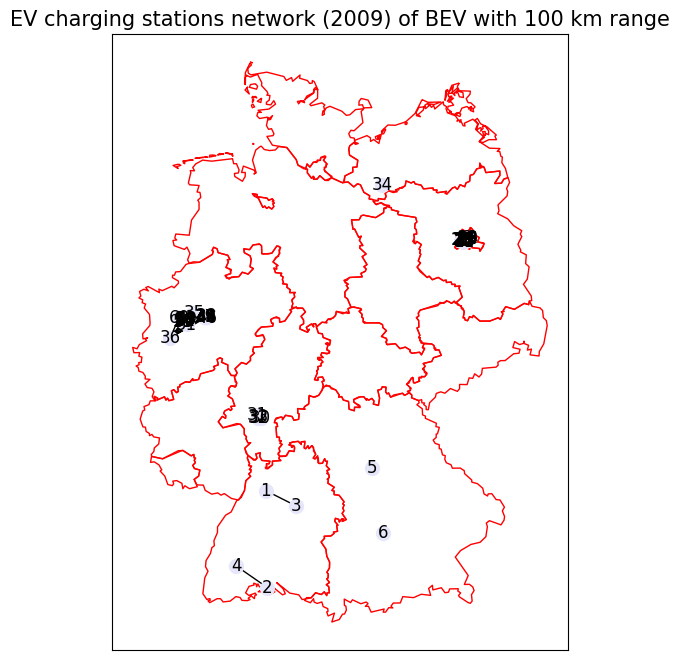

In [23]:
create_network(2009)

In [24]:
# create_network(2010)

In [25]:
# create_network(2011)

In [26]:
# create_network(2012)

In [27]:
create_network(2013)

OperationalError: attempt to write a readonly database

In [ ]:
create_network(2014)

In [ ]:
create_network(2015)

In [ ]:
create_network(2016)

In [ ]:
create_network(2017)

In [ ]:
create_network(2018)

In [ ]:
# create_network(2019)

In [ ]:
# create_network(2020)

In [ ]:
# create_network(2021)

In [ ]:
# create_network(2022)